Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247


Load Data

In [ ]:
# subject data
subject = 4
X_test, y_test, X_train_valid, y_train_valid = import_data_subject(subject)


# DeepConv, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.2926], Training accuracy [39.62%]
Epoch [10], Validation loss [1.9541], Validation accuracy [23.02%]
Epoch [20], Training loss [1.1530], Training accuracy [50.51%]
Epoch [20], Validation loss [2.9276], Validation accuracy [24.56%]
Epoch [30], Training loss [1.0516], Training accuracy [56.15%]
Epoch [30], Validation loss [3.4597], Validation accuracy [25.15%]
Epoch [40], Training loss [0.9355], Training accuracy [61.64%]
Epoch [40], Validation loss [3.7672], Validation accuracy [26.31%]
Epoch [50], Training loss [0.8324], Training accuracy [65.87%]
Epoch [50], Validation loss [4.0527], Validation accuracy [25.73%]
Epoch [60], Training loss [0.7327], Training accuracy [70.30%]
Epoch [60], Validation loss [4.3905], Validation accuracy [24.76%]
Epoch [70], Training loss [0.6507], Training accuracy [75.69%]
Epoch [70], Validation loss [4.7246], Validation accuracy [23.40%]
Epoch [80], Training loss [0.5499], Training accuracy [79.10%]
Epoch [80]

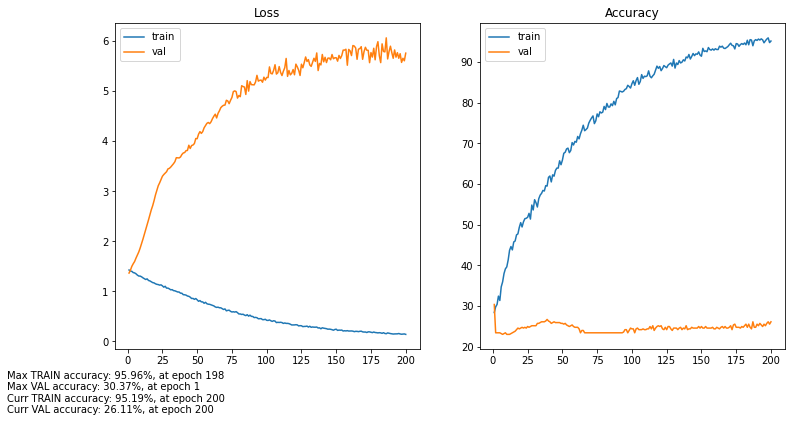

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3788], Training accuracy [29.95%]
Epoch [10], Validation loss [1.4015], Validation accuracy [21.28%]
Epoch [20], Training loss [1.3482], Training accuracy [36.95%]
Epoch [20], Validation loss [1.4466], Validation accuracy [21.28%]
Epoch [30], Training loss [1.2456], Training accuracy [44.73%]
Epoch [30], Validation loss [1.6236], Validation accuracy [21.28%]
Epoch [40], Training loss [1.1453], Training accuracy [49.30%]
Epoch [40], Validation loss [1.8423], Validation accuracy [21.28%]
Epoch [50], Training loss [1.0746], Training accuracy [52.50%]
Epoch [50], Validation loss [2.0050], Validation accuracy [21.28%]
Epoch [60], Training loss [0.9944], Training accuracy [56.20%]
Epoch [60], Validation loss [2.1536], Validation accuracy [21.28%]
Epoch [70], Training loss [0.9053], Training accuracy [60.57%]
Epoch [70], Validation loss [2.2740], Validation accuracy [21.28%]
Epoch [80], Training loss [0.8029], Training accuracy [65.97%]
Epoch [80]

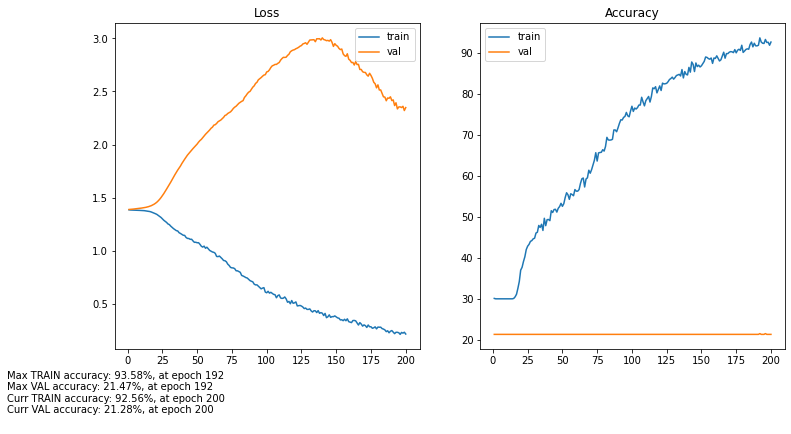

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv1, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3164], Training accuracy [38.41%]
Epoch [10], Validation loss [1.5087], Validation accuracy [14.31%]
Epoch [20], Training loss [1.2260], Training accuracy [45.65%]
Epoch [20], Validation loss [1.7371], Validation accuracy [15.47%]
Epoch [30], Training loss [1.1529], Training accuracy [49.88%]
Epoch [30], Validation loss [2.0173], Validation accuracy [15.86%]
Epoch [40], Training loss [1.0319], Training accuracy [57.41%]
Epoch [40], Validation loss [2.2828], Validation accuracy [16.25%]
Epoch [50], Training loss [0.9372], Training accuracy [60.96%]
Epoch [50], Validation loss [2.3909], Validation accuracy [16.44%]
Epoch [60], Training loss [0.8165], Training accuracy [66.65%]
Epoch [60], Validation loss [2.4524], Validation accuracy [18.18%]
Epoch [70], Training loss [0.6936], Training accuracy [72.58%]
Epoch [70], Validation loss [2.4369], Validation accuracy [20.31%]
Epoch [80], Training loss [0.5675], Training accuracy [78.71%]
Epoch [80]

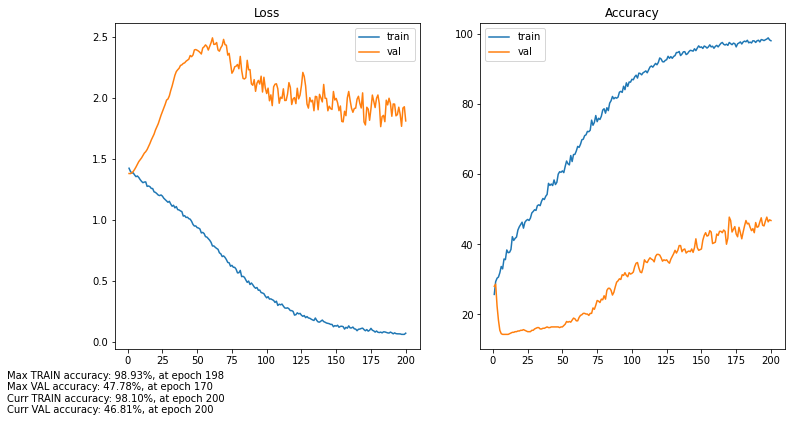

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3774], Training accuracy [28.44%]
Epoch [10], Validation loss [1.4069], Validation accuracy [27.66%]
Epoch [20], Training loss [1.3695], Training accuracy [29.12%]
Epoch [20], Validation loss [1.4091], Validation accuracy [28.63%]
Epoch [30], Training loss [1.3438], Training accuracy [36.56%]
Epoch [30], Validation loss [1.4225], Validation accuracy [25.92%]
Epoch [40], Training loss [1.2680], Training accuracy [43.12%]
Epoch [40], Validation loss [1.4411], Validation accuracy [25.73%]
Epoch [50], Training loss [1.1903], Training accuracy [45.99%]
Epoch [50], Validation loss [1.5017], Validation accuracy [32.69%]
Epoch [60], Training loss [1.1176], Training accuracy [52.02%]
Epoch [60], Validation loss [1.5888], Validation accuracy [33.27%]
Epoch [70], Training loss [1.0581], Training accuracy [55.57%]
Epoch [70], Validation loss [1.6220], Validation accuracy [32.50%]
Epoch [80], Training loss [0.9776], Training accuracy [59.55%]
Epoch [80]

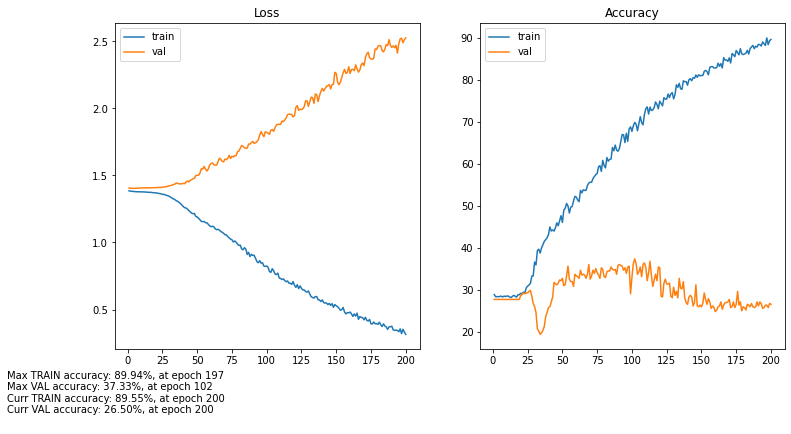

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))